# Sleep stage classification from polysomnography (PSG) EEG data

Code adapted from https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html

In this notebook, we load 10 samples from the PSG sleep study using the MNE python package: https://mne.tools/stable/index.html. The aim is to do multilable classification of different sleep states from EEG traces.

The first sample will act as test data, the rest of the samples are used training data for a convolutional neural network (CNN). A very simple training regimen is implemented, wherein training is done on the full training dataset (no cross-validation).

Literature/refs:
https://github.com/agramfort/hiparis_ml_eeg/blob/main/6-dl_sleep_staging.ipynb

https://arxiv.org/pdf/1610.01683.pdf

https://ieeexplore.ieee.org/document/8307462/authors#authors

## 1: Load PSG data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers

from utils import load_psg_samples, DATA_READERS, eegs_power_band

2023-10-10 11:56:23.597553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
n_subjects = 10
subject_ids = list(range(n_subjects))
sleep_data_files = fetch_data(subjects=subject_ids, recording=[1])

data_format = "edf"
channel = "Fpz-Cz"

raw = load_psg_samples(sleep_data_files, DATA_READERS[data_format], picks=channel)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /Users/maxverbiest/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Extracting EDF parameters from /Users/maxverbiest/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' rec

## 2: Epoch data
Every epoch will be 30 seconds long. For each epoch, an associated sleep-state lable is available. Then, data are split into test and training sets.

In [5]:
annotation_desc_2_event_id = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
}
event_id = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3/4": 3,
    "Sleep stage R": 4,
}

epochs = []
# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
for edf, annotation in raw:
    annotation.crop(annotation[1]["onset"] - (30 * 60), annotation[-2]["onset"] + (30 * 60))
    edf.set_annotations(annotation, emit_warning=False)
    events, _ = mne.events_from_annotations(
        edf, event_id=annotation_desc_2_event_id, chunk_duration=30.0
    )

    tmax = 30.0 - (1.0 / edf.info["sfreq"])  # tmax is included
    epoched = mne.Epochs(
        raw=edf,
        events=events,
        event_id=event_id,
        tmin=0.0,
        tmax=tmax,
        baseline=None,
    )
    epochs.append(epoched)

del raw
epochs

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1025 matching events found
No baseline correction applied
0 projection items activated
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
952 matching events found
No baseline correction applied
0 projection items activated
Used Annotations descriptions: ['S

[<Epochs |  841 events (good & bad), 0 – 29.99 s, baseline off, ~7 kB, data not loaded,
  'Sleep stage W': 188
  'Sleep stage 1': 58
  'Sleep stage 2': 250
  'Sleep stage 3/4': 220
  'Sleep stage R': 125>,
 <Epochs |  1103 events (good & bad), 0 – 29.99 s, baseline off, ~7 kB, data not loaded,
  'Sleep stage W': 157
  'Sleep stage 1': 109
  'Sleep stage 2': 562
  'Sleep stage 3/4': 105
  'Sleep stage R': 170>,
 <Epochs |  1025 events (good & bad), 0 – 29.99 s, baseline off, ~7 kB, data not loaded,
  'Sleep stage W': 128
  'Sleep stage 1': 94
  'Sleep stage 2': 545
  'Sleep stage 3/4': 95
  'Sleep stage R': 163>,
 <Epochs |  952 events (good & bad), 0 – 29.99 s, baseline off, ~7 kB, data not loaded,
  'Sleep stage W': 140
  'Sleep stage 1': 61
  'Sleep stage 2': 485
  'Sleep stage 3/4': 57
  'Sleep stage R': 209>,
 <Epochs |  1235 events (good & bad), 0 – 29.99 s, baseline off, ~7 kB, data not loaded,
  'Sleep stage W': 200
  'Sleep stage 1': 166
  'Sleep stage 2': 620
  'Sleep stage 3/

In [6]:
X_train = []
y_train = []
for epoch in epochs[1:]:
    epoch_data = epoch.get_data().reshape(*epoch.get_data().shape, 1)
    epoch_labels = epoch.events[:, 2]

    X_train.append(epoch_data)
    y_train.append(epoch_labels)
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
print(X_train.shape, y_train.shape)

Using data from preloaded Raw for 1103 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1103 events and 3000 original time points ...
Using data from preloaded Raw for 1025 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1025 events and 3000 original time points ...
Using data from preloaded Raw for 952 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 952 events and 3000 original time points ...
Using data from preloaded Raw for 1235 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1235 events and 3000 original time points ...
Using data from preloaded Raw for 672 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 672 events and 3000 original time points ...
Using data from preloaded Raw for 843 events and 3000 original time points ...
0 bad epochs dropped

In [ ]:
X_test = epochs[0].get_data().reshape(*epochs[0].get_data().shape, 1)
y_test = epochs[0].events[:, 2]

print(X_test.shape, y_test.shape)

## 3: Define the CNN architecture
Architecture is partly based on https://arxiv.org/pdf/1610.01683.pdf

In [687]:
model = models.Sequential()

input_shape = (1, 3000, 1)
model.add(layers.Conv2D(20, (1, 200), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((1, 20)))
model.add(layers.Conv2D(30, (1, 100), activation='relu'))
model.add(layers.MaxPooling2D((1, 10)))

model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(5))
model.add(layers.Softmax())

model.summary()

Model: "sequential_157"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_129 (Conv2D)         (None, 1, 2801, 20)       4020      
                                                                 
 max_pooling2d_197 (MaxPooli  (None, 1, 140, 20)       0         
 ng2D)                                                           
                                                                 
 conv2d_130 (Conv2D)         (None, 1, 41, 30)         60030     
                                                                 
 max_pooling2d_198 (MaxPooli  (None, 1, 4, 30)         0         
 ng2D)                                                           
                                                                 
 flatten_67 (Flatten)        (None, 120)               0         
                                                                 
 dense_123 (Dense)           (None, 50)             

## 4: Train and evaluate CNN classifier

In [713]:
class_ids, counts = np.unique(y_train, return_counts=True)
class_weights = dict(zip(class_ids, ((1 / counts) * (len(y_train) / 2)) ))

print(class_ids, counts, counts.sum())
print(class_weights)

model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=150,
    class_weight=class_weights,
    validation_data=(X_test, y_test)
)

[0 1 2 3 4] [1572  706 4062 1263 1469] 9072
{0: 2.885496183206107, 1: 6.424929178470255, 2: 1.116691285081241, 3: 3.5914489311163895, 4: 3.0878148400272294}
Epoch 1/10
61/61 [==============================] - 12s 181ms/step - loss: 4.0259 - accuracy: 0.1246 - val_loss: 1.6097 - val_accuracy: 0.2189
Epoch 2/10
61/61 [==============================] - 12s 194ms/step - loss: 4.0245 - accuracy: 0.1834 - val_loss: 1.6104 - val_accuracy: 0.1495
Epoch 3/10
61/61 [==============================] - 12s 198ms/step - loss: 4.0250 - accuracy: 0.1316 - val_loss: 1.6071 - val_accuracy: 0.2990
Epoch 4/10
61/61 [==============================] - 12s 205ms/step - loss: 4.0245 - accuracy: 0.2114 - val_loss: 1.6123 - val_accuracy: 0.1495
Epoch 5/10
61/61 [==============================] - 13s 211ms/step - loss: 4.0246 - accuracy: 0.1454 - val_loss: 1.6100 - val_accuracy: 0.1495
Epoch 6/10
61/61 [==============================] - 13s 217ms/step - loss: 4.0248 - accuracy: 0.1604 - val_loss: 1.6135 - val_ac

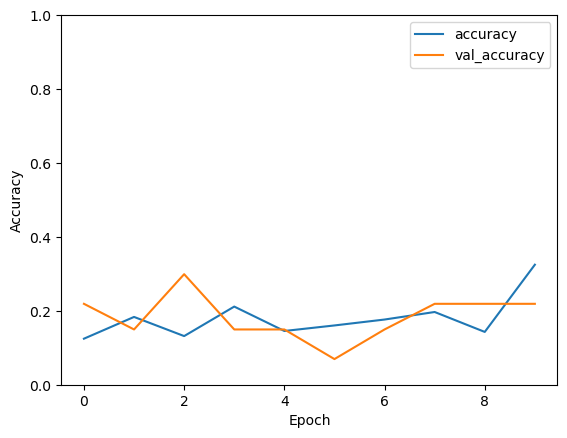

27/27 - 0s - loss: 1.6173 - accuracy: 0.2189 - 188ms/epoch - 7ms/step


In [715]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)